In [2]:
import pandas as pd

In [3]:
import seaborn as sns

In [40]:
exam = pd.read_csv('exam.csv')

In [5]:
user_answer = pd.read_csv('user_answer.csv')
user_answer['time'] = pd.to_datetime(user_answer['time'], format='%Y-%m-%d %H-%M-%S')

In [41]:
user_answer.sort_values(by='user_id')

,exam_id,user_id,task_ind,answer,verdict,time,time_diff
3582,2,1,3,2,WA,2023-12-20 10:26:50,1.0
1927,1,1,8,2,WA,2023-12-15 16:16:58,33.0
1934,1,1,15,3,WA,2023-12-15 16:27:38,82.0
1928,1,1,9,0,WA,2023-12-15 16:17:04,6.0
1935,1,1,16,3,WA,2023-12-15 16:29:26,108.0
...,...,...,...,...,...,...,...
3665,2,529,2,0,OK,2023-12-20 10:22:46,3.0
3812,2,530,1,1,WA,2023-12-20 10:42:50,9.0
3815,2,530,4,3,WA,2023-12-20 10:43:49,2.0
3813,2,530,2,0,OK,2023-12-20 10:42:52,2.0


In [6]:
user_answer = user_answer.sort_values(by='time')
user_answer['time_diff'] = user_answer['time'].diff().apply(lambda x: x.total_seconds())

In [49]:
uagrouped = user_answer.groupby(['exam_id','task_ind'])
df_grouped = pd.concat([df.reset_index(drop=True) for _, df in uagrouped]).fillna(0)

In [50]:
df_grouped

,exam_id,user_id,task_ind,answer,verdict,time,time_diff
0,1,102,1,2,WA,2023-12-15 10:00:08,0.0
1,1,90,1,1,OK,2023-12-15 10:00:10,2.0
2,1,91,1,0,WA,2023-12-15 10:00:49,27.0
3,1,89,1,1,OK,2023-12-15 10:00:52,3.0
4,1,70,1,0,WA,2023-12-15 10:00:56,2.0
...,...,...,...,...,...,...,...
525,2,398,4,3,WA,2023-12-20 14:02:13,1.0
526,2,30,4,3,WA,2023-12-20 14:42:06,30.0
527,2,231,4,3,WA,2023-12-20 14:55:15,23.0
528,2,515,4,1,WA,2023-12-20 15:14:52,15.0


In [86]:
suspicios_1 = {u_id:0 for u_id in user_answer['user_id'].unique()}
for wind in df_grouped.rolling(window=5,min_periods=1):
    user = wind.iloc[-1]
    diff = 0
    for i in range(len(wind)-1):
        x = wind.iloc[i]
        diff += x['time_diff']
        if x['task_ind'] == user['task_ind'] and x['answer'] == user['answer'] and diff <= 20:
            suspicios_1[user['user_id']] += 1
            suspicios_1[x['user_id']] += 1
print(max(suspicios_1,key=lambda x: suspicios_1[x]))
print(suspicios_1[47])

47
66


<Axes: ylabel='Count'>

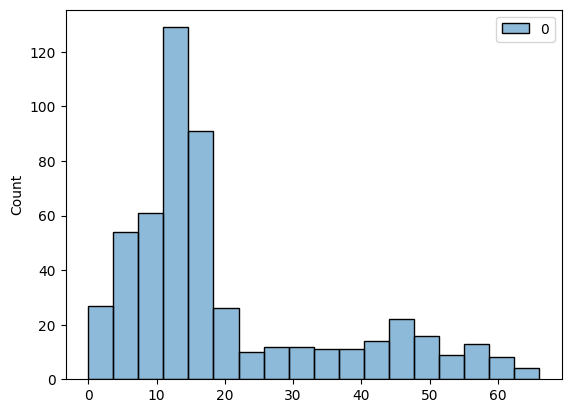

In [87]:
sns.histplot(suspicios_1.values())

In [161]:
lst = pd.DataFrame(list(suspicios_1.items()),columns=['user_id','susp_1'])

In [162]:
u_ans = pd.read_csv('user_answer.csv').drop(columns=['time'])

In [163]:
u_ans = u_ans.merge(u_ans, on=['exam_id','task_ind'])

In [164]:
u_ans = u_ans[u_ans['user_id_x'] != u_ans['user_id_y']]

In [165]:
u_ans = u_ans.copy()
u_ans['is_eq'] = (u_ans['answer_x'] == u_ans['answer_y'])
u_ans['is_eq_WA'] = u_ans['is_eq'] & (u_ans['verdict_x'] == 'WA')

In [166]:
lst = lst.merge(u_ans.groupby('user_id_x').agg({'is_eq':'sum'}).reset_index().rename(columns={'is_eq':'susp_2'}), left_on='user_id',right_on='user_id_x')
lst = lst.drop(columns=['user_id_x'])

In [167]:
lst = lst.merge(u_ans.groupby('user_id_x').agg({'is_eq_WA':'sum'}).reset_index().rename(columns={'is_eq_WA':'susp_3'}), left_on='user_id',right_on='user_id_x')

In [170]:
lst = lst.drop(columns=['user_id_x'])

<Axes: xlabel='variable', ylabel='value'>

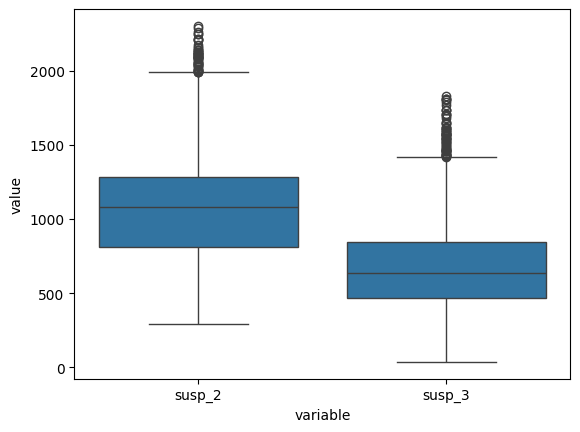

In [174]:
df_long = pd.melt(lst, value_vars=['susp_2', 'susp_3'])
sns.boxplot(data=df_long, x='variable', y='value')